In [68]:
import numpy as np  # Manipulation de tableaux numériques
import pandas as pd  # Manipulation de données tabulaires
import cv2  # Traitement d'images
import os  # Interactions avec le système de fichiers
from collections import Counter  # Comptage des occurrences
from sklearn.model_selection import train_test_split  # Pour diviser les données
import matplotlib.pyplot as plt  # Visualisation
import seaborn as sns  # Visualisation avancée
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report




In [69]:
# Configuration de base
chemin_donnees = "ches"  # Chemin vers les données d'images
categories = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']  # Catégories de maladies
taille_image = (64, 64)  # Taille pour redimensionner les images
K = 3  # Nombre de voisins pour l'algorithme KNN

In [70]:
# Initialisation des listes pour stocker les chemins des images et leurs catégories
image_paths = []
categories_list = []

# Parcourir chaque catégorie
for category in categories:
    category_path = os.path.join(chemin_donnees, category)
    
    if os.path.exists(category_path):  # Vérifier si le chemin existe
        for image_name in os.listdir(category_path):  # Parcourir les images de la catégorie
            image_path = os.path.join(category_path, image_name)
            if os.path.isfile(image_path):  # Vérifier si c'est bien un fichier
                image_paths.append(image_path)
                categories_list.append(category)
    else:
        print(f"Chemin non trouvé : {category_path}")

# Créer un DataFrame à partir des chemins et catégories
df = pd.DataFrame({'image_path': image_paths, 'category': categories_list})

# Sauvegarder le DataFrame au format CSV
donnecsv = "data.csv"  # Remplacez par le chemin de sortie souhaité
df.to_csv(donnecsv, index=False)

print(f"Fichier CSV généré avec succès : {donnecsv}")


Fichier CSV généré avec succès : data.csv


In [71]:
df.head

<bound method NDFrame.head of                                 image_path       category
0            ches\COVID19\COVID19(450).jpg        COVID19
1            ches\COVID19\COVID19(451).jpg        COVID19
2            ches\COVID19\COVID19(452).jpg        COVID19
3            ches\COVID19\COVID19(453).jpg        COVID19
4            ches\COVID19\COVID19(454).jpg        COVID19
..                                     ...            ...
164  ches\TURBERCULOSIS\Tuberculosis-5.png  TURBERCULOSIS
165  ches\TURBERCULOSIS\Tuberculosis-6.png  TURBERCULOSIS
166  ches\TURBERCULOSIS\Tuberculosis-7.png  TURBERCULOSIS
167  ches\TURBERCULOSIS\Tuberculosis-8.png  TURBERCULOSIS
168  ches\TURBERCULOSIS\Tuberculosis-9.png  TURBERCULOSIS

[169 rows x 2 columns]>

In [72]:
df.shape

(169, 2)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  169 non-null    object
 1   category    169 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB


In [74]:
df.tail()

,image_path,category
164,ches\TURBERCULOSIS\Tuberculosis-5.png,TURBERCULOSIS
165,ches\TURBERCULOSIS\Tuberculosis-6.png,TURBERCULOSIS
166,ches\TURBERCULOSIS\Tuberculosis-7.png,TURBERCULOSIS
167,ches\TURBERCULOSIS\Tuberculosis-8.png,TURBERCULOSIS
168,ches\TURBERCULOSIS\Tuberculosis-9.png,TURBERCULOSIS


In [75]:
df.describe()

,image_path,category
count,169,169
unique,169,4
top,ches\COVID19\COVID19(450).jpg,NORMAL
freq,1,73


In [76]:
df['category'].unique()

array(['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'], dtype=object)

In [77]:
df['category'].value_counts()

category
NORMAL           73
COVID19          36
PNEUMONIA        30
TURBERCULOSIS    30
Name: count, dtype: int64

In [78]:
# Fonction pour charger les images et leurs étiquettes
def charger_donnees(chemin_donnees, categories):
    images = []  # Liste pour stocker les images
    indexation = []  # Liste pour stocker indexetion
    for index, categorie in enumerate(categories):
        chemin_categorie = os.path.join(chemin_donnees, categorie)
        if not os.path.exists(chemin_categorie):
            print(f"Dossier {chemin_categorie} n'existe pas.")
            continue
        for nom_fichier in os.listdir(chemin_categorie):
            chemin_image = os.path.join(chemin_categorie, nom_fichier)
            try:
                image = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    raise ValueError(f"Image {chemin_image} est invalide.")
                image_redim = cv2.resize(image, taille_image).flatten()
                images.append(image_redim)
                indexation.append(index)
            except Exception as e:
                print(e)
                continue
    return np.array(images), np.array(indexation)

In [79]:
# Charger les données
images, indexation = charger_donnees(chemin_donnees, categories)

In [80]:
# Diviser les données en ensembles d'entraînement et de test
images_entrainement, images_test, indexation_entrainement, indexation_test = train_test_split(
    images, indexation, test_size=0.2, random_state=42)

In [81]:
# Fonction pour calculer la distance euclidienne entre deux images
def calculer_distance(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

In [82]:
# Fonction KNN pour prédire la catégorie d'une image de test
def knn(images_entrainement, indexation_entrainement, image_test,k, categories):
    distances = []   # Liste vide pour stocker les distances entre l'image de test et les images d'entraînement
    # Calculer la distance entre l'image de test et chaque image d'entraînement
    for i in range(len(images_entrainement)):
        distance = calculer_distance(images_entrainement[i], image_test)   # Calculer la distance pour l'image courante
        distances.append((distance, indexation_entrainement[i]))  # Ajouter la distance et l'étiquette correspondante
    # Trier les distances par ordre croissant
    distances_triees = sorted(distances, key=lambda x: x[0])
    # Prendre les k plus proches voisins
    voisins_proches = distances_triees[:k]
    # Trouver la catégorie la plus fréquente parmi les voisins
    index_voisins = [voisin[1] for voisin in voisins_proches] # Extraire les étiquettes des voisins
    categorie_predite = Counter(index_voisins).most_common(1)[0][0] # Trouver l'étiquette la plus fréquente
    return categories[categorie_predite]  # Retourner le nom de la catégorie

In [83]:
# Fonction pour évaluer le modèle
def evaluer_modele(images_entrainement, indexation_entrainement, images_test, indexation_test, k, categories):
    predictions = []
    for image_test in images_test:
        prediction = knn(images_entrainement, indexation_entrainement, image_test, k, categories)
        predictions.append(prediction)
    
    # Convertir les prédictions en indices correspondants
    predictions_indices = [categories.index(prediction) for prediction in predictions]

    # Initialiser les variables pour la matrice de confusion
    TP = FP = TN = FN = 0
    for i in range(len(indexation_test)):
        if predictions_indices[i] == indexation_test[i]:
            if predictions_indices[i] == 1:  # Exemple, catégorie "COVID19" est à l'indice 1
                TP += 1
            else:
                TN += 1
        else:
            if predictions_indices[i] == 1:
                FP += 1
            else:
                FN += 1
     # 3. Calcul de la précision (Precision)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    # 4. Calcul du rappel
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
     # 5. Calcul de la F-mesure
    f_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    # 6. Calcul de la précision globale
    accuracy = (TP + TN) / len(indexation_test)

    return predictions_indices, accuracy, precision, recall, f_score

In [84]:
# Affichage des résultats après la mise à jour
predictions_indices, accuracy, precision, recall, f_score = evaluer_modele(images_entrainement, indexation_entrainement, images_test, indexation_test, K, categories)

# Affichage des résultats
print("\nMétriques du modèle :")
print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"F-score : {f_score}")
print(f"Précision Globale : {accuracy}")



Métriques du modèle :
Précision : 0.7
Rappel : 0.8235294117647058
F-score : 0.7567567567567567
Précision Globale : 0.7352941176470589



Matrice de confusion :
[[ 5  3  0  2]
 [ 0 14  0  0]
 [ 0  3  2  0]
 [ 1  0  0  4]]

Rapport de classification :
               precision    recall  f1-score   support

      COVID19       0.83      0.50      0.62        10
       NORMAL       0.70      1.00      0.82        14
    PNEUMONIA       1.00      0.40      0.57         5
TURBERCULOSIS       0.67      0.80      0.73         5

     accuracy                           0.74        34
    macro avg       0.80      0.68      0.69        34
 weighted avg       0.78      0.74      0.71        34



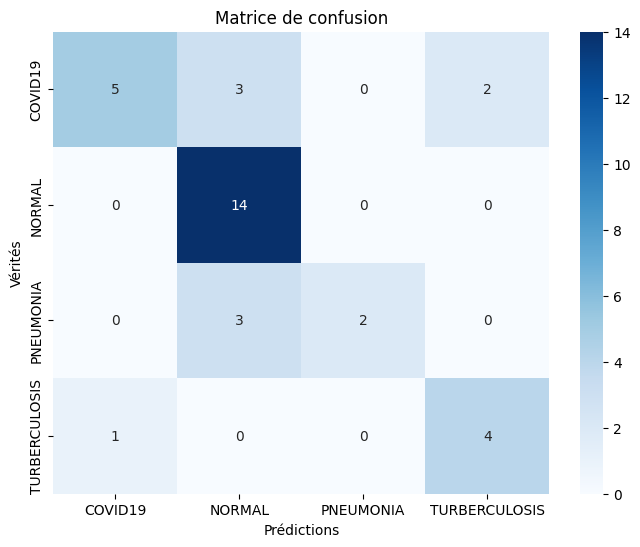

In [86]:
# Matrice de confusion avec les indices de test
matrice_confusion = confusion_matrix(indexation_test, predictions_indices)
print("\nMatrice de confusion :")
print(matrice_confusion)

# Rapport de classification avec les données de test
print("\nRapport de classification :")
print(classification_report(indexation_test, predictions_indices, target_names=categories))

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrice_confusion, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion')
plt.show()


In [87]:
# Exemple de prédiction pour une image spécifique
image_path = 'chest/TURBERCULOSIS/Tuberculosis-336.png'
def predire_chemin_image(chemin_image, images_entrainement, indexation_entrainement,k, taille_image, categories):
    try:
        image = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Erreur : l'image {chemin_image} est invalide.")
        image_redim = cv2.resize(image, taille_image).flatten()
        categorie_predite = knn(images_entrainement, indexation_entrainement, image_redim, k, categories)
        print(f"Catégorie prédite pour l'image {chemin_image} : {categorie_predite}")
        return categorie_predite
    except Exception as e:
        print(f"Erreur lors du traitement de l'image : {e}")
        return None



In [88]:

# Prédiction de l'image d'exemple
predire_chemin_image(image_path, images_entrainement, indexation_entrainement, K, taille_image, categories)

Catégorie prédite pour l'image chest/TURBERCULOSIS/Tuberculosis-336.png : TURBERCULOSIS


'TURBERCULOSIS'